#### Instructions
###### Follow the instructions given in comments prefixed with ## and write your code below that.
###### Also fill the partial code in given blanks. 
###### Don't make any changes to the rest part of the codes

### Answer the questions given at the end of this notebook within your report.


### You would need to submit your GitHub repository link. Refer to the Section 6: Final Submission on the PDF document for the details.


In [46]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial import distance
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [47]:
import wandb
wandb.login(key="1053509b7ce2a2774f63f795750f455d2dd713f6")
wandb.init(project='distance_classification_project')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/arun/.netrc


In [48]:
## Reading the image plaksha_Faculty.jpg
img = cv2.imread('Plaksha_Faculty.jpg')
  
## Convert the image to grayscale
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
# Loading the required haar-cascade xml classifier file
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  
# Applying the face detection method on the grayscale image. 
## Change the parameters for better detection of faces in your case.
faces_rect = face_cascade.detectMultiScale(gray_img, 1.05, 4, minSize=(25,25), maxSize=(50,50))
 
# Define the text and font parameters
text = "face detected" ## The text you want to write
font = cv2.FONT_HERSHEY_SIMPLEX  ## Font type
font_scale = 0.5  ## Font scale factor
font_color = 0, 0, 255  ## Text color in BGR format (here, it's red)
font_thickness = 2  ## Thickness of the text

  
# Iterating through rectangles of detected faces
for (x, y, w, h) in faces_rect:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
    # Use cv2.putText to add the text to the image, Use text, font, font_scale, font_color, font_thickness here
    cv2.putText(img, text, (x, y-10), font, font_scale, font_color, font_thickness)
    
## Display the image and window title should be "Total number of face detected are #"  
cv2.imshow(f"Detected faces: {len(faces_rect)}", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [49]:
wandb.log({
    "number_of_faces_detected": len(faces_rect),
    "face_detection_image": wandb.Image(img)
})

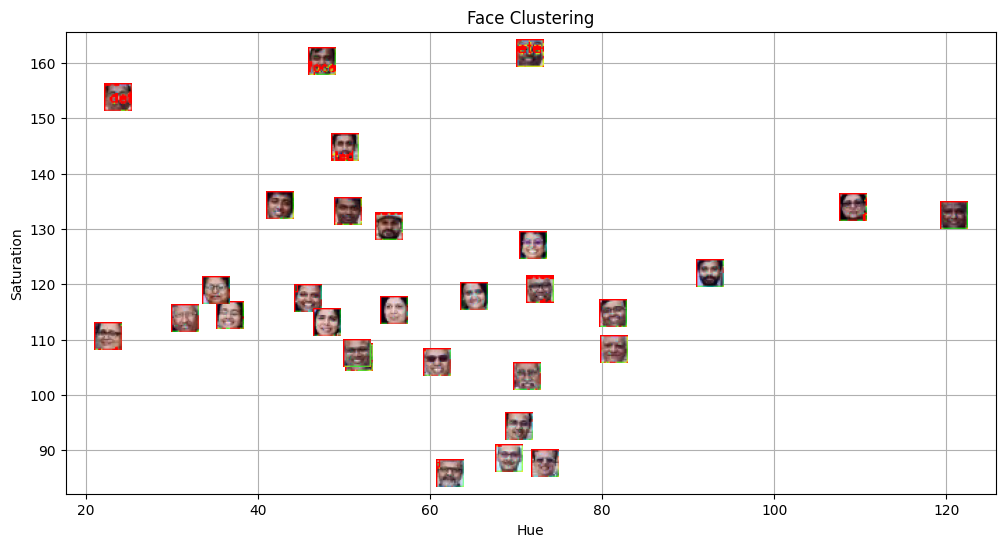

In [50]:
# Extract face region features (Hue and Saturation)
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) ## call the img and convert it from BGR to HSV and store in img_hsv
hue_saturation = []
face_images = []  # To store detected face images

for (x, y, w, h) in faces_rect:
    face = img_hsv[y:y + h, x:x + w]
    hue = np.mean(face[:, :, 0])
    saturation = np.mean(face[:, :, 1])
    hue_saturation.append((hue, saturation))
    face_images.append(face)

hue_saturation = np.array(hue_saturation)

## Perform k-Means clustering on hue_saturation and store in kmeans
kmeans = KMeans(n_clusters=3, random_state=42).fit(hue_saturation)
#centroids = kmeans.cluster_centers_
#labels = kmeans.labels_

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the clustered faces with custom markers
for i, (x,y,w,h ) in enumerate(faces_rect):
    im = OffsetImage(cv2.cvtColor(cv2.resize(face_images[i], (20, 20)), cv2.COLOR_HSV2RGB))
    ab = AnnotationBbox(im, (hue_saturation[i, 0], hue_saturation[i, 1]), frameon=False, pad=0)
    ax.add_artist(ab)
    plt.plot(hue_saturation[i, 0], hue_saturation[i, 1])
    

## Put x label
plt.xlabel('Hue')
## Put y label
plt.ylabel('Saturation')
## Put title
plt.title('Face Clustering')
## Put grid
plt.grid(True)
## show the plot
plt.show()

In [51]:
wandb.log({
    "face_clustering_plot": wandb.Image(plt),
    "clusters_with_centroids": wandb.Image(plt),
    "template_matching_plot": wandb.Image(plt)
})

wandb.log({
    "number_of_clusters": kmeans.n_clusters,
    "inertia": kmeans.inertia_,
    "cluster_centers": kmeans.cluster_centers_.tolist()
})

<Figure size 640x480 with 0 Axes>

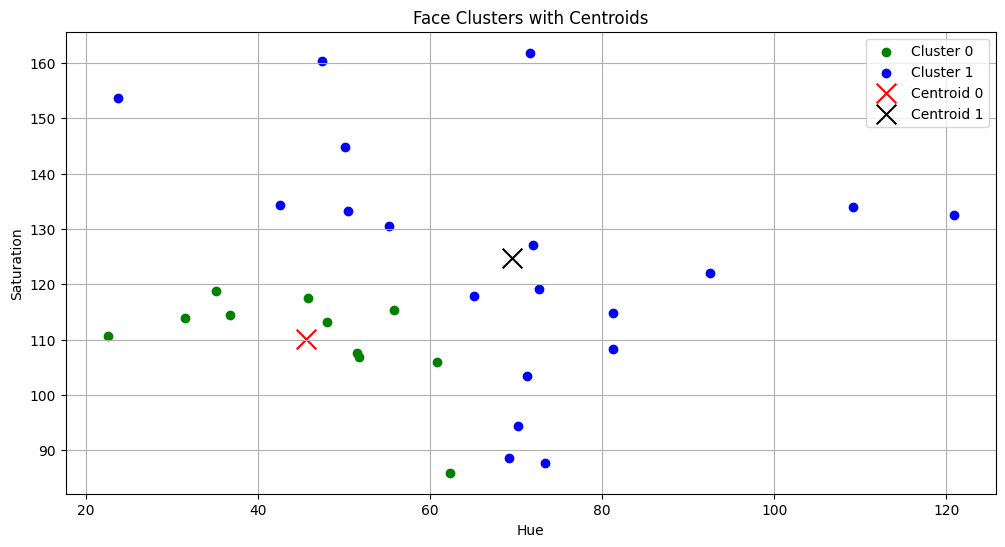

In [52]:
# Create an empty list to store legend labels
legend_labels = []

# Create lists to store points for each cluster
cluster_0_points = []
cluster_1_points = []

# Your code for scatter plot goes here
fig, ax = plt.subplots(figsize=(12, 6))
for i, (x, y, w, h) in enumerate(faces_rect):
    if kmeans.labels_[i] == 0:
        cluster_0_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))
    else:
        cluster_1_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))


cluster_0_points = np.array(cluster_0_points)
# Plot points for cluster 0 in green
plt.scatter(cluster_0_points[:, 0], cluster_0_points[:, 1], c='green', label='Cluster 0')

cluster_1_points = np.array(cluster_1_points)
# Plot points for cluster 1 in blue
plt.scatter(cluster_1_points[:, 0], cluster_1_points[:, 1], c='blue', label='Cluster 1')

# Calculate and plot centroids
centroid_0 = np.mean(cluster_0_points, axis=0)
centroid_1 = np.mean(cluster_1_points, axis=0)

# Plot both the centroid for cluster 0 and cluster 1 
plt.scatter(centroid_0[0], centroid_0[1], c='red', marker='x', s=200, label='Centroid 0')
plt.scatter(centroid_1[0], centroid_1[1], c='black', marker='x', s=200, label='Centroid 1')

## Put x label
plt.xlabel('Hue')
## Put y label
plt.ylabel('Saturation')
## Put title
plt.title('Face Clusters with Centroids')
## Add a legend
plt.legend()
## Add grid
plt.grid(True)
## Show the plot
plt.show()

In [53]:
## Read the class of the template image 'Dr_Shashi_Tharoor.jpg' using cv2 and store it in template_img
template_img = cv2.imread('Dr_Shashi_Tharoor.jpg')
# Detect face  in the template image after converting it to gray and store it in template_faces
gray = cv2.cvtColor(template_img, cv2.COLOR_BGR2GRAY)
template_faces = face_cascade.detectMultiScale(gray, 1.05, 4, minSize=(25,25), maxSize=(300,300))

# Draw rectangles around the detected faces
for (x, y, w, h) in template_faces:
    cv2.rectangle(template_img, (x, y), (x + w, y + h), (0, 255, 0), 3)
cv2.imshow(f"Template Image - Faces Detected: {len(template_faces)}", template_img)
cv2.waitKey(0)
cv2.destroyAllWindows()      

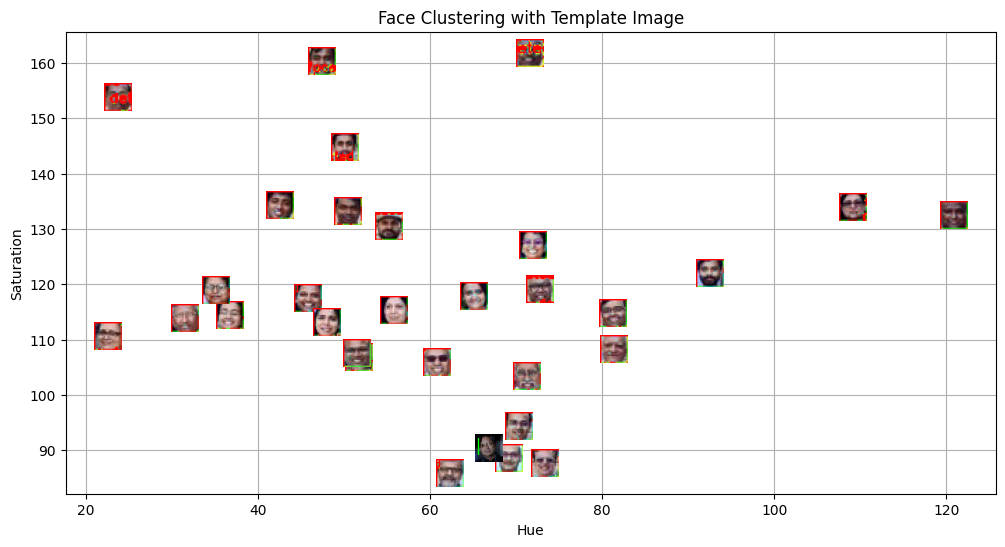

In [54]:
# Convert the template image to HSV color space and store it in template_hsv
template_hsv = cv2.cvtColor(template_img, cv2.COLOR_BGR2HSV)

# Extract hue and saturation features from the template image as we did it for detected faces.
template_hue = np.mean(template_hsv[:, :, 0])
template_saturation = np.mean(template_hsv[:, :, 1])

# Predict the cluster label for the template image and store it in template_label
template_features = np.array([[template_hue, template_saturation]])
template_label = kmeans.predict(template_features)[0]

# Create a figure and axis for visualization
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the clustered faces with custom markers (similar to previous code)
for i, (x, y, w, h) in enumerate(faces_rect):
    color = 'red' if kmeans.labels_[i] == 0 else 'blue'
    im = OffsetImage(cv2.cvtColor(cv2.resize(face_images[i], (20, 20)), cv2.COLOR_HSV2RGB))
    ab = AnnotationBbox(im, (hue_saturation[i, 0], hue_saturation[i, 1]), frameon=False, pad=0)
    ax.add_artist(ab)
    plt.plot(hue_saturation[i, 0], hue_saturation[i, 1], 'o', markersize=5, color=color)

# Plot the template image in the respective cluster
if template_label == 0:
    color = 'red'
else:
    color = 'blue'
im = OffsetImage(cv2.cvtColor(cv2.resize(template_img, (20, 20)), cv2.COLOR_BGR2RGB))
ab = AnnotationBbox(im, (template_hue, template_saturation), frameon=False, pad=0)
ax.add_artist(ab)

## Put x label
plt.xlabel('Hue')
## Put y label
plt.ylabel('Saturation')
## Put title
plt.title('Face Clustering with Template Image')
## Add grid
plt.grid(True)
## show plot
plt.show()

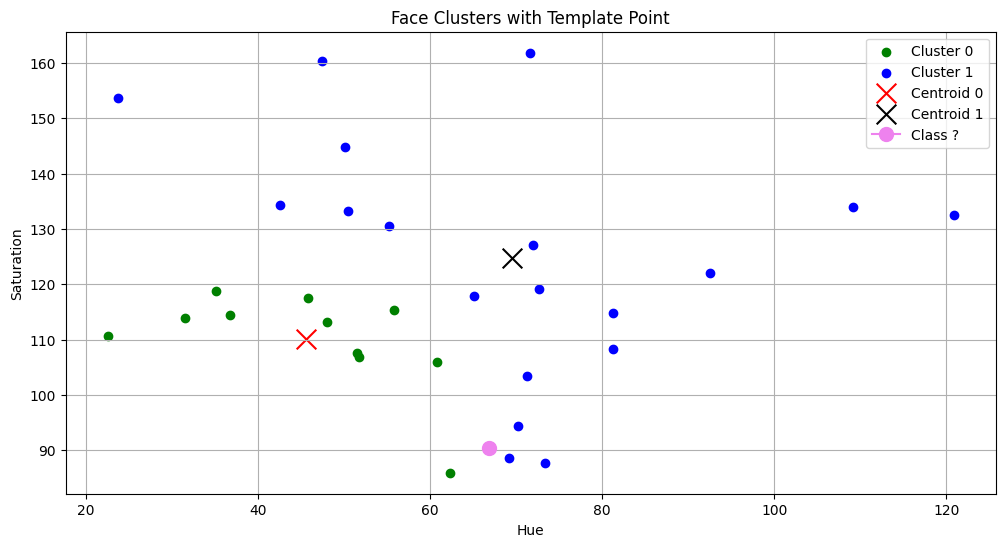

In [55]:
# Create an empty list to store legend labels
legend_labels = []

# Create lists to store points for each cluster
cluster_0_points = []
cluster_1_points = []

# Your code for scatter plot goes here
fig, ax = plt.subplots(figsize=(12, 6))
for i, (x, y, w, h) in enumerate(faces_rect):
    if kmeans.labels_[i] == 0:
        cluster_0_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))
    else:
        cluster_1_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))

# Plot points for cluster 0 in green
cluster_0_points = np.array(cluster_0_points)
plt.scatter(cluster_0_points[:, 0], cluster_0_points[:, 1], c='green', label='Cluster 0')

# Plot points for cluster 1 in blue
cluster_1_points = np.array(cluster_1_points)
plt.scatter(cluster_1_points[:, 0], cluster_1_points[:, 1], c='blue', label='Cluster 1')

# Calculate and plot centroids for both the clusters
centroid_0 = np.mean(cluster_0_points, axis=0)
centroid_1 = np.mean(cluster_1_points, axis=0)
plt.scatter(centroid_0[0], centroid_0[1], c='red', marker='x', s=200, label='Centroid 0')
plt.scatter(centroid_1[0], centroid_1[1], c='black', marker='x', s=200, label='Centroid 1')
plt.plot(template_hue, template_saturation, marker='o', c='violet', markersize=10, label='Class ?')

## Put x label
plt.xlabel('Hue')
## Put y label
plt.ylabel('Saturation')
## Put title
plt.title('Face Clusters with Template Point')
## Add a legend
plt.legend()
## Add grid
plt.grid(True)
## show the plot
plt.show()
                                            ## End of the lab 5 ##

In [56]:
wandb.finish()

inertia,▁
number_of_clusters,▁
number_of_faces_detected,▁
inertia,10912.32992
number_of_clusters,3
number_of_faces_detected,30


## Report:
## Answer the following questions within your report:


#### 1. What are the common distance metrics used in distance-based classification algorithms? 

#### 2. What are some real-world applications of distance-based classification algorithms? 

#### 3. Explain various distance metrics. 

#### 4. What is the role of cross validation in model performance? 

#### 5. Explain variance and bias in terms of KNN? 

In [1]:
# test mod 1